# Figure 5: Convergence Distributions

<div style="text-align: justify">
This is the code used to create **Figure 5** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The Figure shows the convergence distribution of the parametric bootstrap under the assumption of Gaussian and Laplacian noise. For an interactive version of the plot see [Figure 4](04_Parametric_BS_Procedure.ipynb).
</div>

## Imports

In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from copy import deepcopy

from applefy.statistics import fpf_2_gaussian_sigma, gaussian_sigma_2_fpf, TTest, \
    LaplaceBootstrapTest
from applefy.statistics.bootstrapping import GaussianBootstrapTest
from applefy.utils import get_number_of_apertures

## Simulate Observations

<div style="text-align: justify">
We want to simulate observations at different separations (i.e. different sample sizes $n$) and for different types of noise. We first compute the number of noise observations available at 2 FWHM and 8 FWHM.
</div>

In [2]:
# -1 for the planet
separation1 = get_number_of_apertures(2*2, 1) - 1
separation2 = get_number_of_apertures(2*8, 1) - 1

print("n = " + str(separation1))
print("n = " + str(separation2))

n = 11
n = 49


Now we can simulate the observations by drawing from a Gaussian and Laplace distribution.

In [3]:
gaussian_noise1 = np.random.normal(0, 1, separation1)
gaussian_noise2 = np.random.normal(0, 1, separation2)

laplacian_noise1 = np.random.laplace(0, 1, separation1)
laplacian_noise2 = np.random.laplace(0, 1, separation2)

<div style="text-align: justify">
Note: Due to pivoting (see chapter 6.3 in the paper) the actual values of the observations in *gaussian_noise1*, *gaussian_noise2*, *laplacian_noise1* and *laplacian_noise2* do not change the resulting distribution of $p(T^* = t | H_0)$.
</div>

## Run the Parametric Bootstrap

As in [Figure 4](04_Parametric_BS_Procedure.ipynb) we run the parametric bootstrap using the [GaussianBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.GaussianBootstrapTest) and [LaplaceBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest) of applefy.

In [4]:
# the Gaussian models
gaussian_test1 = GaussianBootstrapTest(gaussian_noise1, num_cpus=64)
gaussian_test2 = GaussianBootstrapTest(gaussian_noise2, num_cpus=64)

# the Laplacian models
laplace_test1 = LaplaceBootstrapTest(laplacian_noise1, num_cpus=64)
laplace_test2 = LaplaceBootstrapTest(laplacian_noise2, num_cpus=64)

Run the actual bootstrapping. Note: The following code cell is computationally expensive. Consider reducing *num_draws* if needed. Also note that [run_bootstrap_experiment](../../03_package/statistics.rst#applefy.statistics.bootstrapping.BootstrapTest.run_bootstrap_experiment) runs much faster if [parallel_sort](https://pypi.org/project/parallel-sort/) is installed. More information are given in the [installation instructions](../../01_getting_started.md#installation).

In [5]:
# Run the Bootstrapping and save the values of T - Gauss
gaussian_T1 = gaussian_test1.run_bootstrap_experiment(
    memory_size=5e6,
    num_noise_values=separation1,
    num_draws=1e9,
    approximation_interval=np.linspace(-7, 7, 100000))

gaussian_T2 = gaussian_test2.run_bootstrap_experiment(
    memory_size=5e6,
    num_noise_values=separation2,
    num_draws=1e9,
    approximation_interval=np.linspace(-7, 7, 100000))

In [6]:
# Run the Bootstrapping and save the values of T - Laplace
laplace_T1 = laplace_test1.run_bootstrap_experiment(
    memory_size=5e6,
    num_noise_values=separation1,
    num_draws=1e9,
    approximation_interval=np.linspace(-7, 7, 100000))

laplace_T2 = laplace_test1.run_bootstrap_experiment(
    memory_size=5e6,
    num_noise_values=separation2,
    num_draws=1e9,
    approximation_interval=np.linspace(-7, 7, 100000))

## Create the Plot

A small function to plot one of the 4 histograms in comparison to the t-distribution.

In [7]:
axis_limit = 7.

def plot_histogram(axis_in,
                   data_in, 
                   df_in, 
                   double=False):
    
    local_data = pd.DataFrame({"T": data_in})
    
    x = np.linspace(-axis_limit, axis_limit, 1000)
    axis_in.plot(x, stats.t.pdf(x, df=df_in),
                 color=sns.color_palette("colorblind")[1], 
                 lw=3,
                 label="$t$-Distribution")
    
    # This hack is needed to get the histogram in the Legend
    if double:
        axis_in.plot(x, stats.t.pdf(x, df=df_in),
                     color=sns.color_palette("colorblind")[1], 
                     lw=3,
                     label="$t$-Distribution")
    
    axis_in.plot(x, stats.norm.pdf(x),
                 color="black",
                 ls="--",
                 lw=2,
                 label="Normal-Distribution")
    
    sns.histplot(data=local_data, 
                 x="T",
                 bins=30, 
                 stat="density", 
                 binrange=(-axis_limit, axis_limit),
                 ax=axis_in,
                 #element="step",
                 legend=True)
    
    axis_in.set_xlim(-axis_limit+0.5, axis_limit-0.5)
    axis_in.set_yscale("log")
    axis_in.yaxis.grid()
    axis_in.tick_params(axis='both', which='major', labelsize=12)

Create the actual plot.

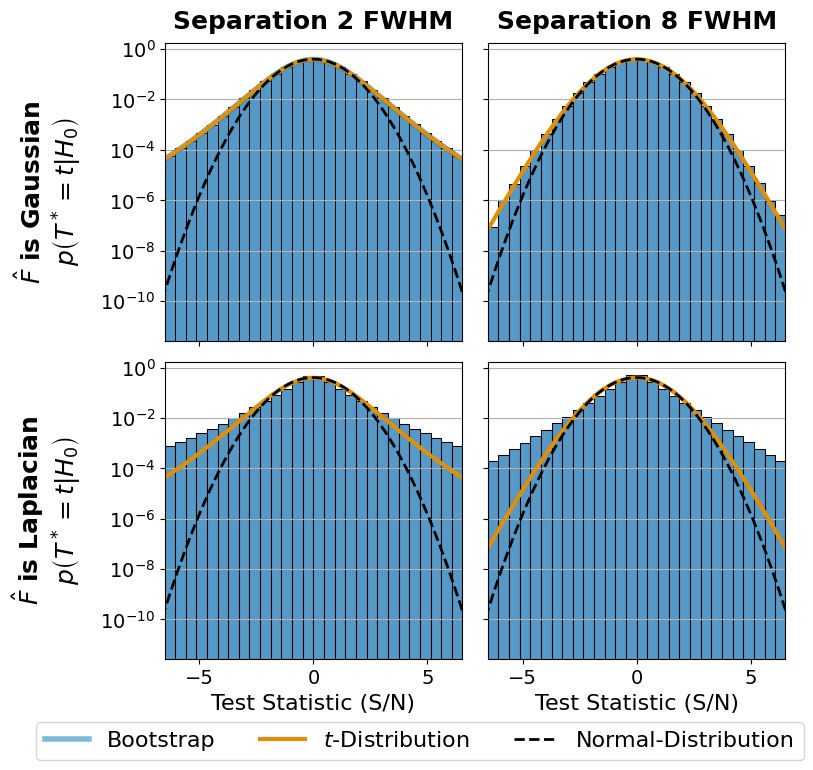

In [8]:
# 1.) Create Plot Layout ---------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
gs0 = fig.add_gridspec(2, 2)
gs0.update(hspace=0.07, wspace=0.09)

ax_inner_gauss = fig.add_subplot(
    gs0[0, 0])
ax_outer_gauss = fig.add_subplot(
    gs0[0, 1], sharex=ax_inner_gauss, sharey=ax_inner_gauss)
ax_inner_laplace = fig.add_subplot(
    gs0[1, 0], sharex=ax_inner_gauss, sharey=ax_inner_gauss)
ax_outer_laplace = fig.add_subplot(
    gs0[1, 1], sharex=ax_inner_gauss, sharey=ax_inner_gauss)

# 2.) Plot the histograms --------------------------------------
idx = np.random.randint(0, gaussian_T1.shape[0]-1, int(1e8))
plot_histogram(
    ax_inner_gauss, 
    gaussian_T1[idx], 
    separation1 - 1, 
    double=True)

plot_histogram(
    ax_outer_gauss, 
    gaussian_T2[idx], 
    separation2 - 1)

plot_histogram(
    ax_inner_laplace, 
    laplace_T1[idx], 
    separation1 - 1)

plot_histogram(
    ax_outer_laplace, 
    laplace_T2[idx], 
    separation2 - 1)

# 3.) turn of tick lables --------------------------------------
plt.setp(ax_outer_gauss.get_yticklabels(), visible=False)
plt.setp(ax_outer_laplace.get_yticklabels(), visible=False)
plt.setp(ax_inner_gauss.get_xticklabels(), visible=False)
plt.setp(ax_outer_gauss.get_xticklabels(), visible=False)
ax_inner_laplace.tick_params(
    axis='both', which='major', labelsize=14)
ax_outer_laplace.tick_params(
    axis='both', which='major', labelsize=14)
ax_inner_gauss.tick_params(
    axis='both', which='major', labelsize=14)
ax_outer_gauss.tick_params(
    axis='both', which='major', labelsize=14)

# 4.) Lables and Titles ----------------------------------------
ax_outer_gauss.set_ylabel("")
ax_outer_laplace.set_ylabel("")
ax_inner_gauss.set_xlabel("")
ax_outer_gauss.set_xlabel("")
ax_inner_gauss.set_ylabel("$p(T=t|H_0)$", size=16)
ax_inner_laplace.set_ylabel("$p(T=t|H_0)$", size=16)

ax_inner_laplace.set_xlabel("Test Statistic (S/N)", size=16)
ax_outer_laplace.set_xlabel("Test Statistic (S/N)", size=16)

ax_inner_gauss.set_ylabel(
    r"$\hat{F}$ is Gaussian" + "\n" + 
    r"$p\left( T^*=t|H_0 \right) $",
    fontweight="bold", size=18,  labelpad=12)

ax_inner_laplace.set_ylabel(
    r"$\hat{F}$ is Laplacian" + "\n" + 
    r"$p\left( T^*=t|H_0 \right) $",
    size=18, fontweight="bold", labelpad=12)


ax_inner_gauss.set_title(
    "Separation 2 FWHM",
    fontsize=18, fontweight="bold", y=1.02)
ax_outer_gauss.set_title(
    "Separation 8 FWHM", 
    fontsize=18, fontweight="bold", y=1.02)

# 5.) Create the legend ---------------------------------------
handles, labels = ax_inner_laplace.get_legend_handles_labels()
handles2, _ = ax_inner_gauss.get_legend_handles_labels()

# For some reason the handles overwite the style and alpha
handles = [handles2[0], handles[0], handles[1],]
labels = ["Bootstrap", labels[0], labels[1],]

handles[0].set_alpha(0.5)
handles[0].set_color(sns.color_palette("colorblind")[0])
handles[0].set_lw(4)

leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(-0.05, -0.03), 
                  fontsize=16,
                  loc='lower left', ncol=3)

# 6.) Show and save the plot ----------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./05_Convergence_distribution_BS.pdf",
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')